# Weather Forecast - Model Preparation

## Import Cleaned Data

Import Libraries

In [1]:
import numpy as np
import pandas as pd

Importing Atmospheric Pressure Data

In [2]:
filename = 'CleanedData/AtmosphericPressure_pascal.csv'
atm_pressure_df = pd.read_csv(filename)
atm_pressure_df.head()

,Unnamed: 0,Month,DAY,2018,2019,2020
0,0,Jan,1,1019.5,1019.3,1019.8
1,1,Jan,2,1019.6,1019.6,1021.6
2,2,Jan,3,1019.9,1022.3,1021.8
3,3,Jan,4,1021.4,1021.0,1021.6
4,4,Jan,5,1021.2,1020.1,1018.8


Importing Temperature (Minimum and Maximum) Data

In [3]:
filename = 'CleanedData/MinimumTemperature_degCelsius.csv'
min_temp_df = pd.read_csv(filename)
min_temp_df.head()

,Unnamed: 0,Month,DAY,2018,2019,2020
0,0,Jan,1,16.3,18.4,14.5
1,1,Jan,2,16.1,19.5,13.2
2,2,Jan,3,15.7,18.4,12.4
3,3,Jan,4,16.0,19.6,12.6
4,4,Jan,5,14.2,20.1,13.6


In [4]:
filename = 'CleanedData/MaximumTemperature_degCelsius.csv'
max_temp_df = pd.read_csv(filename)
max_temp_df.head()

,Unnamed: 0,Month,DAY,2018,2019,2020
0,0,Jan,1,26.1,28.9,26.9
1,1,Jan,2,27.4,29.8,22.1
2,2,Jan,3,27.2,30.0,23.1
3,3,Jan,4,29.0,30.0,24.4
4,4,Jan,5,26.9,31.0,27.8


Importing Relative Humidity Data

In [5]:
filename = 'CleanedData/RelativeHumidity_Percent.csv'
rel_humidity_df = pd.read_csv(filename)
rel_humidity_df.head()

,Unnamed: 0,Month,DAY,2018,2019,2020
0,0,Jan,1,25.333333,26.500000,26.416667
1,1,Jan,2,27.583333,30.416667,29.000000
2,2,Jan,3,24.416667,25.833333,27.583333
3,3,Jan,4,27.166667,28.000000,32.083333
4,4,Jan,5,29.916667,30.583333,33.583333


Importing Wind Speed Data

In [6]:
filename = 'CleanedData/WindSpeed_Knot.csv'
wind_speed_df = pd.read_csv(filename)
wind_speed_df.head()

,Unnamed: 0,Month,DAY,2018,2019,2020
0,0,Jan,1,9.666667,12.0,17
1,1,Jan,2,12.000000,15.0,19
2,2,Jan,3,11.666667,10.0,16
3,3,Jan,4,12.333333,12.0,22
4,4,Jan,5,12.333333,15.0,13


## Flattening Time Series Data

In [7]:
atm_pressure_df.head(3)

,Unnamed: 0,Month,DAY,2018,2019,2020
0,0,Jan,1,1019.5,1019.3,1019.8
1,1,Jan,2,1019.6,1019.6,1021.6
2,2,Jan,3,1019.9,1022.3,1021.8


In [8]:
list_date = []
list_data = []

for year in ['2018', '2019', '2020']:
    month_data, day_data = list(atm_pressure_df['Month']), list(atm_pressure_df['DAY'])
    atm_data = list(atm_pressure_df[year])
    
    month_convert = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06',
                    'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}
    
    for month, day, data in zip(month_data, day_data, atm_data):
        day = '0' + str(day) if len(str(day)) == 1 else str(day)
        month = month_convert[month]
        
        date = day +'-' + month + '-' + year
        
        if (year in ['2018', '2019']) & (month == '02') & (day == '29'):
            continue
        
        list_date.append(date)
        list_data.append(data)
        
date_series = pd.to_datetime(list_date, dayfirst=True)
data_series = pd.Series(list_data, name='Atmospheric Pressure')

result_df = pd.DataFrame( { 'Date': date_series, 'Atmospheric Pressure': data_series } )
result_df.set_index(['Date'], inplace=True)

result_df

,Atmospheric Pressure
Date,
2018-01-01,1019.5
2018-01-02,1019.6
2018-01-03,1019.9
2018-01-04,1021.4
2018-01-05,1021.2
...,...
2020-12-27,1020.7
2020-12-28,1019.1
2020-12-29,1019.4


Creating Python Function to Handle Flattening

In [9]:
def flatten_data_table(input_df, table_name):
    list_date = []
    list_data = []

    for year in ['2018', '2019', '2020']:
        month_data, day_data = list(input_df['Month']), list(input_df['DAY'])
        table_data = list(input_df[year])

        month_convert = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06',
                        'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

        for month, day, data in zip(month_data, day_data, table_data):
            day = '0' + str(day) if len(str(day)) == 1 else str(day)
            month = month_convert[month]

            date = day +'-' + month + '-' + year

            if (year in ['2018', '2019']) & (month == '02') & (day == '29'):
                continue

            list_date.append(date)
            list_data.append(data)

    date_series = pd.to_datetime(list_date, dayfirst=True)
    data_series = pd.Series(list_data, name = table_name)

    result_df = pd.DataFrame( { 'Date': date_series, table_name: data_series } )
    result_df.set_index(['Date'], inplace=True)

    return result_df

In [10]:
atm_pressure_df = flatten_data_table(atm_pressure_df, 'Atmospheric Pressure')
atm_pressure_df

,Atmospheric Pressure
Date,
2018-01-01,1019.5
2018-01-02,1019.6
2018-01-03,1019.9
2018-01-04,1021.4
2018-01-05,1021.2
...,...
2020-12-27,1020.7
2020-12-28,1019.1
2020-12-29,1019.4


In [11]:
min_temp_df = flatten_data_table(min_temp_df, 'Minimum Temperature')
min_temp_df

,Minimum Temperature
Date,
2018-01-01,16.3
2018-01-02,16.1
2018-01-03,15.7
2018-01-04,16.0
2018-01-05,14.2
...,...
2020-12-27,16.1
2020-12-28,16.5
2020-12-29,15.2


In [14]:
max_temp_df = flatten_data_table(max_temp_df, 'Maximum Temperature')
max_temp_df

,Maximum Temperature
Date,
2018-01-01,26.1
2018-01-02,27.4
2018-01-03,27.2
2018-01-04,29.0
2018-01-05,26.9
...,...
2020-12-27,30.8
2020-12-28,32.8
2020-12-29,31.6


In [12]:
rel_humidity_df = flatten_data_table(rel_humidity_df, 'Relative Humidity')
rel_humidity_df

,Relative Humidity
Date,
2018-01-01,25.333333
2018-01-02,27.583333
2018-01-03,24.416667
2018-01-04,27.166667
2018-01-05,29.916667
...,...
2020-12-27,31.166667
2020-12-28,30.541667
2020-12-29,30.666667


In [13]:
wind_speed_df = flatten_data_table(wind_speed_df, 'Wind Speed')
wind_speed_df

,Wind Speed
Date,
2018-01-01,9.666667
2018-01-02,12.000000
2018-01-03,11.666667
2018-01-04,12.333333
2018-01-05,12.333333
...,...
2020-12-27,12.000000
2020-12-28,13.000000
2020-12-29,14.000000


## Converting Data to a Single Data Frame

In [18]:
data_df = pd.concat([atm_pressure_df, min_temp_df, max_temp_df, rel_humidity_df, wind_speed_df], axis=1)
data_df.head()

,Atmospheric Pressure,Minimum Temperature,Maximum Temperature,Relative Humidity,Wind Speed
Date,,,,,
2018-01-01,1019.5,16.3,26.1,25.333333,9.666667
2018-01-02,1019.6,16.1,27.4,27.583333,12.000000
2018-01-03,1019.9,15.7,27.2,24.416667,11.666667
2018-01-04,1021.4,16.0,29.0,27.166667,12.333333
2018-01-05,1021.2,14.2,26.9,29.916667,12.333333


Inspecting Data

In [19]:
data_df.describe()

,Atmospheric Pressure,Minimum Temperature,Maximum Temperature,Relative Humidity,Wind Speed
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,1017.692349,20.070347,31.706296,53.802768,8.407968
std,1.749240,2.391588,3.270707,22.734055,3.714949
min,1012.000000,9.600000,20.600000,14.250000,0.000000
25%,1016.500000,19.000000,29.500000,29.416667,6.000000
50%,1017.700000,20.300000,31.700000,60.166667,8.000000
75%,1018.800000,21.600000,34.000000,75.343750,10.666667
max,1022.700000,26.800000,40.600000,87.791667,22.000000


In [20]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Atmospheric Pressure  1096 non-null   float64
 1   Minimum Temperature   1096 non-null   float64
 2   Maximum Temperature   1096 non-null   float64
 3   Relative Humidity     1096 non-null   float64
 4   Wind Speed            1096 non-null   float64
dtypes: float64(5)
memory usage: 51.4 KB


### Visualization of Data for Correlation and Relationship

Checking Correlation Between Variables Before Modelling

In [44]:
data_corr_df = data_df.corr()
data_corr_df

,Atmospheric Pressure,Minimum Temperature,Maximum Temperature,Relative Humidity,Wind Speed
Atmospheric Pressure,1.000000,-0.422223,-0.426914,-0.035103,0.226173
Minimum Temperature,-0.422223,1.000000,0.210624,0.439647,-0.377640
Maximum Temperature,-0.426914,0.210624,1.000000,-0.455011,0.014702
Relative Humidity,-0.035103,0.439647,-0.455011,1.000000,-0.467535
Wind Speed,0.226173,-0.377640,0.014702,-0.467535,1.000000


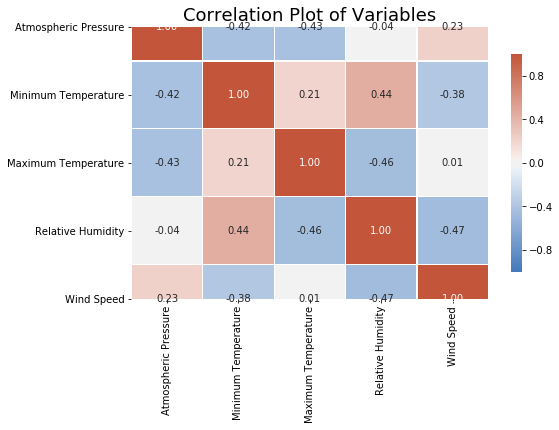

In [62]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(8, 5))

plt.title('Correlation Plot of Variables', fontsize=18)

cmap = sb.diverging_palette(250, 20, as_cmap=True)
sb.heatmap(data_corr_df, annot=True, fmt=".2f", cmap=cmap, vmin= -1, vmax=1, linewidth=0.3, cbar_kws={"shrink": .8})

plt.show()

In [67]:
from sklearn.preprocessing import normalize

normalized_df = normalize(data_df, axis=0)
normalized_df = pd.DataFrame(normalized_df, index=date_series, 
                             columns=["Atmospheric Pressure", "Minimum Temperature", "Maximum Temperature", 
                                      "Relative Humidity", "Wind Speed"])
normalized_df

,Atmospheric Pressure,Minimum Temperature,Maximum Temperature,Relative Humidity,Wind Speed
2018-01-01,0.030260,0.024360,0.024734,0.013102,0.031768
2018-01-02,0.030263,0.024061,0.025966,0.014266,0.039436
2018-01-03,0.030272,0.023463,0.025776,0.012628,0.038341
2018-01-04,0.030316,0.023911,0.027482,0.014050,0.040531
2018-01-05,0.030310,0.021221,0.025492,0.015472,0.040531
...,...,...,...,...,...
2020-12-27,0.030295,0.024061,0.029188,0.016119,0.039436
2020-12-28,0.030248,0.024658,0.031083,0.015796,0.042722
2020-12-29,0.030257,0.022716,0.029946,0.015860,0.046009
2020-12-30,0.030260,0.021670,0.031083,0.016399,0.026291


<function matplotlib.pyplot.show(*args, **kw)>

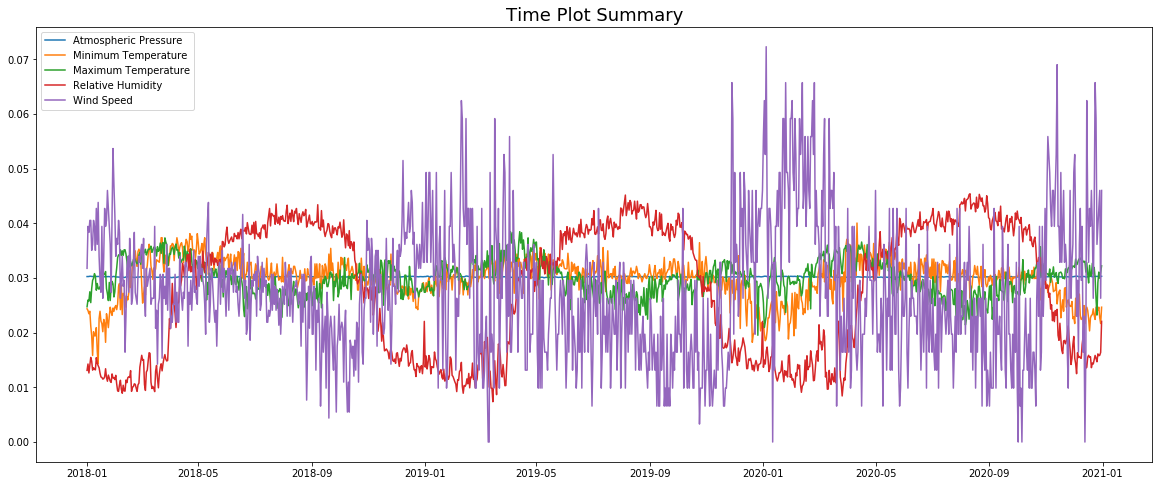

In [73]:
plt.figure(figsize=(20,8))

plt.title("Time Plot Summary", fontsize=18)
plt.plot(normalized_df)

plt.legend(["Atmospheric Pressure", "Minimum Temperature", "Maximum Temperature", "Relative Humidity", "Wind Speed"])

plt.show

### Plot Smoothing

Performing a data filter on the normalized data to smooth the plot for better visualization of data

In [92]:
from scipy.signal import savgol_filter

filtered_df = normalized_df.apply(lambda x : savgol_filter(x, 53, 3))
# fft_df = np.fft.ifftn(normalized_df)

filtered_df = pd.DataFrame(filtered_df, index=date_series, 
                             columns=["Atmospheric Pressure", "Minimum Temperature", "Maximum Temperature", 
                                      "Relative Humidity", "Wind Speed"])

filtered_df.head()

,Atmospheric Pressure,Minimum Temperature,Maximum Temperature,Relative Humidity,Wind Speed
2018-01-01,0.030276,0.022426,0.027329,0.014066,0.035357
2018-01-02,0.030278,0.022100,0.027305,0.014044,0.035861
2018-01-03,0.030279,0.021806,0.027298,0.014011,0.036321
2018-01-04,0.030280,0.021545,0.027307,0.013967,0.036738
2018-01-05,0.030280,0.021315,0.027330,0.013914,0.037114


<function matplotlib.pyplot.show(*args, **kw)>

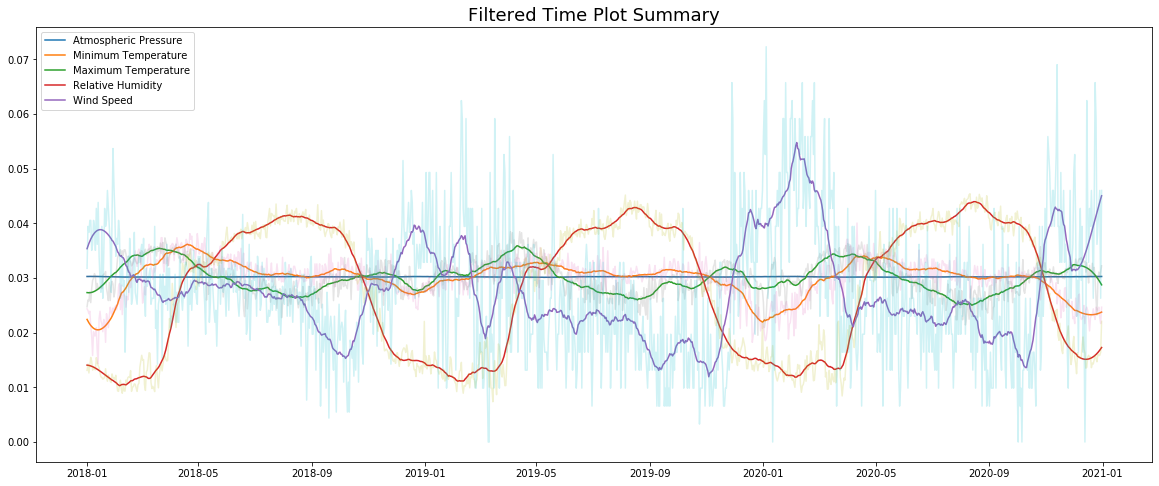

In [97]:
plt.figure(figsize=(20,8))

plt.title("Filtered Time Plot Summary", fontsize=18)

plt.plot(filtered_df)
plt.plot(normalized_df, alpha=0.2)

plt.legend(["Atmospheric Pressure", "Minimum Temperature", "Maximum Temperature", "Relative Humidity", "Wind Speed"])

plt.show